In [2]:
import math
import matplotlib.pyplot as plt
import pyspark


Also try maximum magnitude of storms for each year, bin them into [0,20], [20,30],[40,50],[50,infty], storm distributions for each year, frequency versus magnitude

In [2]:
sc = pyspark.SparkContext(appName="StormApp").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/12/02 17:41:37 WARN Utils: Your hostname, Johns-MacBook-Air.local, resolves to a loopback address: 127.0.0.1; using 192.168.1.177 instead (on interface en0)
25/12/02 17:41:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/02 17:41:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# NOAA storm data, only data from 2020-2025
rdd = sc.textFile("/Users/johnhutchens/Desktop/DistComp/GroupProject/storm_g2020.csv")

In [4]:
header = rdd.first()
rdd1 = rdd.filter(lambda x: x != header)

In [5]:
rdd1.getNumPartitions()

11

In [6]:
rdd_split = rdd1.map(lambda x: x.split(","))

In [7]:
rdd_split.take(2)

[['202006',
  '24',
  '1620',
  '202006',
  '24',
  '1620',
  '149684.0',
  '902190',
  'GEORGIA',
  '13.0',
  '2020',
  'June',
  'Thunderstorm Wind',
  'C',
  '321',
  'WORTH',
  'TAE',
  '24-JUN-20 16:20:00',
  'EST-5',
  '24-JUN-20 16:20:00',
  '0',
  '0',
  '0',
  '0',
  '0.00K',
  '0.00K',
  '911 Call Center',
  '50.0',
  'EG',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '1.0',
  'W',
  'DOLES',
  '1.0',
  'W',
  'DOLES',
  '31.7',
  '-83.89',
  '31.7',
  '-83.89',
  '"As is typical during summer',
  ' scattered afternoon thunderstorms produced a few instances of damaging winds."',
  '"A power line was blown down on Highway 32W.  Hail was also noted',
  ' but the size was unknown."',
  'CSV'],
 ['202006',
  '20',
  '1930',
  '202006',
  '20',
  '1930',
  '149048.0',
  '898391',
  'KANSAS',
  '20.0',
  '2020',
  'June',
  'Hail',
  'C',
  '137',
  'NORTON',
  'GLD',
  '20-JUN-20 19:30:00',
  'CST-6',
  '20-JUN-20 19:30:00',
  '0',
  '0',
  '0',
  '0',
  '',
  '',
  'Pu

In [8]:
rdd_MAG = rdd_split.map(lambda x: (x[10],x[27]))

In [9]:
def safe_float(x):
    try:
        return float(x)
    except:
        return float('nan') 

In [10]:
rdd_MAG_num = rdd_MAG.map(lambda x: (int(x[0]),safe_float(x[1])))


In [11]:
rdd_MAG_clean = rdd_MAG_num.filter(lambda x: x[1] != 0 and x[1] != float('nan'))

In [12]:
rdd_MAG_clean = rdd_MAG_clean.filter(lambda x: not math.isnan(x[1]))

In [13]:
rdd_MAG_clean.collect()

[(2020, 50.0),
 (2020, 1.0),
 (2020, 0.75),
 (2020, 52.0),
 (2020, 1.25),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 1.75),
 (2020, 59.0),
 (2020, 50.0),
 (2020, 52.0),
 (2020, 51.0),
 (2020, 56.0),
 (2020, 56.0),
 (2020, 0.75),
 (2020, 51.0),
 (2020, 52.0),
 (2020, 78.0),
 (2020, 56.0),
 (2020, 51.0),
 (2020, 43.0),
 (2020, 54.0),
 (2020, 54.0),
 (2020, 76.0),
 (2020, 53.0),
 (2020, 57.0),
 (2020, 61.0),
 (2020, 56.0),
 (2020, 1.0),
 (2020, 50.0),
 (2020, 0.75),
 (2020, 1.5),
 (2020, 1.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.88),
 (2020, 1.25),
 (2020, 50.0),
 (2020, 70.0),
 (2020, 52.0),
 (2020, 0.75),
 (2020, 51.0),
 (2020, 61.0),
 (2020, 59.0),
 (2020, 1.75),
 (2020, 1.75),
 (2020, 31.0),
 (2020, 42.0),
 (2020, 56.0),
 (2020, 52.0),
 (2020, 50.0),
 (2020, 50.0),
 (2020, 50.0),
 (2020, 0.88),
 (2020, 2.0),
 (2020, 0.75),
 (2020, 0.75),
 (2020, 0.88),
 (2020, 0.75),
 (2020, 65.0),
 (2020, 50.0),
 (2020, 45.0),
 (2020, 57.0),
 (2020, 56.0),

In [14]:
# average magnitude of storm per year
# where magnitude is the measured extent of the magnitude type 
# ~ only used for wind speeds (in knots) and hail size
# (in inches to the hundredth). 
avg_per_year = (
    rdd_MAG_clean
    .mapValues(lambda v: (v, 1))                               
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))       
    .mapValues(lambda x: x[0] / x[1])                           
)

In [15]:
data_avg = avg_per_year.collect()

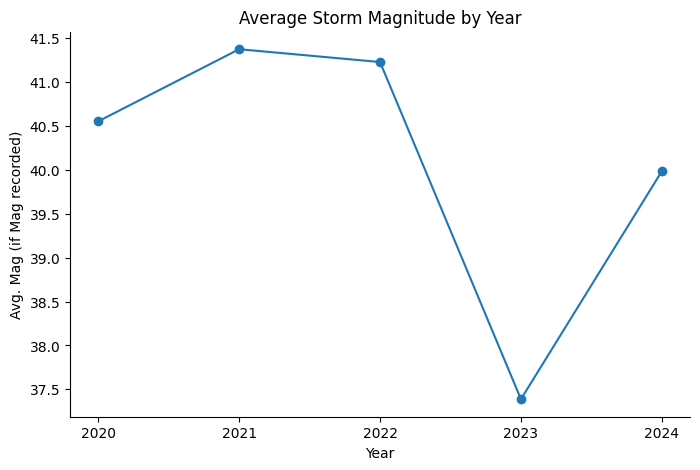

In [16]:
data = [d for d in data_avg if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Average Storm Magnitude by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Avg. Mag (if Mag recorded)")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [17]:
# count per year of storms with magnitude over 50
count_over_50 = (
    rdd_MAG_clean
    .filter(lambda x: x[1] > 50)
    .map(lambda x: (x[0], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [18]:
data_raw50 = count_over_50.collect()

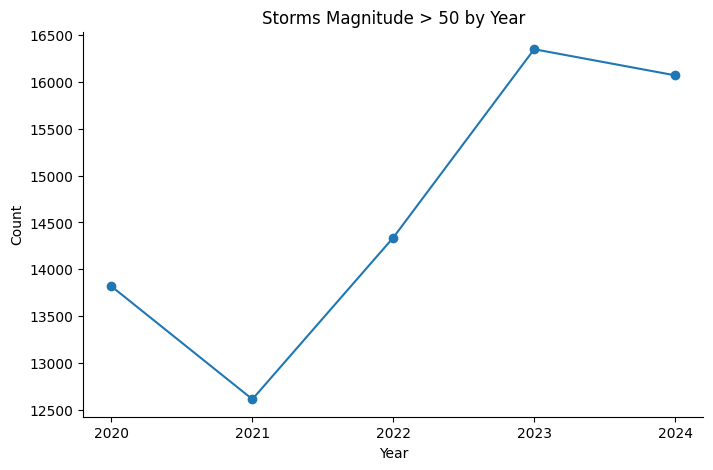

In [19]:
data = [d for d in data_raw50 if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Storms Magnitude > 50 by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Count")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [20]:
# count per year of storms with magnitude over 20
count_over_20 = (
    rdd_MAG_clean
    .filter(lambda x: x[1] > 20)
    .map(lambda x: (x[0], 1))
    .reduceByKey(lambda a, b: a + b)
)

In [21]:
data_raw20 = count_over_20.collect()

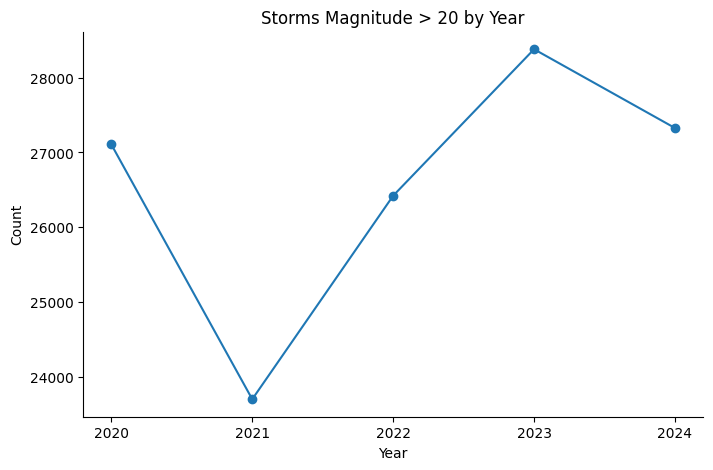

In [22]:
data = [d for d in data_raw20 if d[0] != 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values, marker='o')
plt.title("Storms Magnitude > 20 by Year")
plt.xlabel("Year")
plt.xticks(years)
plt.ylabel("Count")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

In [1]:
# data from cluster
Mag_avg = [(1956, 25.859776), (1968, 16.581135430916554), (1980, 23.556587030716724), (1992, 13.93978228532815), (2004, 28.107152942033082), (2016, 36.32653774792064), (1957, 22.12578417266187), (1969, 22.415851851851848), (1981, 20.120121348314605), (1993, 11.016807557460016), (2005, 27.452700836970074), (2017, 36.07670769047847), (2006, 27.316508086972423), (1958, 18.438554852320674), (1970, 23.182207014542342), (1982, 17.259675659290693), (1994, 14.785240238550783), (2018, 37.517813232567185), (2007, 30.273805922490382), (1959, 16.760522496371554), (1971, 20.102508735150245), (1983, 19.615917592051435), (1995, 13.75919410502765), (2019, 38.73558691920124), (1960, 19.26983268983269), (1972, 21.8782292637465), (1984, 15.535411700975079), (1996, 25.274750703145212), (2008, 30.26302314333427), (2020, 40.55421507785983), (1961, 19.76013487475915), (1973, 20.635117682558842), (1985, 13.744806451612881), (1997, 26.48587601575989), (2009, 30.997518574015462), (2021, 41.37634317909039), (2022, 41.230272005707725), (1998, 23.98730893186023), (2010, 34.78079645461425), (1962, 19.714313725490197), (1974, 15.64944920993228), (1986, 14.570430270270244), (2023, 37.386630183328336), (1963, 22.889767441860464), (1975, 19.927039408867), (1987, 20.702474952613045), (1999, 23.141849606528968), (2011, 32.67677048813127), (1964, 24.832115555555557), (1976, 19.488025078369905), (1988, 18.138394823788513), (2012, 33.1720035309373), (2024, 39.98587465564733), (2000, 24.119115772157365), (1965, 21.969654340836016), (1977, 20.283526894865524), (1989, 18.469205128205182), (2013, 34.767845169905655), (2001, 23.517313525372334), (2025, 38.25813587045423), (2002, 24.372625482625832), (2014, 34.476626743121), (1966, 21.489701897018968), (1978, 22.33315659679408), (1990, 16.696452452452466), (2015, 34.94548490889397), (1955, 18.00974025974026), (1967, 20.080884476534298), (1979, 19.180765575501585), (1991, 15.063861788617917), (2003, 28.819635405690544)]
Mag_over50 = [(2004, 7986), (1956, 224), (1968, 318), (1980, 1110), (1992, 1459), (2016, 11516), (2005, 7958), (2017, 12480), (1957, 210), (1969, 365), (1981, 651), (1993, 762), (1958, 244), (1970, 357), (1982, 852), (1994, 1761), (2006, 9169), (2018, 10435), (1959, 159), (1971, 371), (1983, 963), (1995, 2061), (2007, 8917), (2019, 13109), (2020, 13817), (2008, 12790), (1960, 203), (1972, 307), (1984, 830), (1996, 5444), (2009, 10721), (2021, 12611), (1961, 252), (1973, 456), (1985, 878), (1997, 4734), (1962, 324), (1974, 464), (1986, 1017), (1998, 6117), (2010, 12053), (2022, 14338), (1999, 4420), (2011, 16199), (2023, 16351), (1963, 304), (1975, 554), (1987, 1153), (2012, 12478), (1964, 375), (1976, 428), (1988, 923), (2024, 16072), (2000, 5510), (1965, 349), (1977, 468), (1989, 1345), (2025, 8199), (2001, 5898), (2013, 10353), (2002, 5959), (2014, 10439), (1966, 309), (1978, 514), (1990, 1123), (1955, 111), (1967, 280), (1979, 509), (1991, 1357), (2015, 9930), (2003, 7983)]
Mag_over20 = [(2004, 14208), (1956, 232), (1968, 397), (1980, 1239), (1992, 1708), (2016, 21828), (1957, 222), (1969, 451), (1981, 731), (1993, 916), (2017, 23200), (2005, 14087), (2006, 17028), (2018, 20690), (1958, 253), (1970, 450), (1982, 923), (1994, 2173), (2007, 16979), (1959, 162), (1971, 471), (1983, 1088), (1995, 2428), (2019, 26506), (2008, 23526), (2020, 27107), (1960, 206), (1972, 397), (1984, 942), (1996, 8696), (1961, 329), (1973, 559), (1985, 961), (1997, 7623), (2021, 23699), (2009, 18692), (2010, 20866), (1998, 9153), (1962, 397), (1974, 559), (1986, 1114), (2022, 26421), (2011, 27276), (1999, 7022), (2023, 28381), (1963, 383), (1975, 656), (1987, 1280), (1964, 451), (1976, 504), (1988, 1095), (2024, 27327), (2012, 22807), (2000, 8181), (2001, 8756), (2013, 18809), (1965, 458), (1977, 553), (1989, 1683), (2025, 13118), (2002, 9716), (2014, 19478), (1966, 391), (1978, 598), (1990, 1377), (1955, 116), (1967, 366), (1979, 590), (1991, 1585), (2015, 19175), (2003, 14438)]

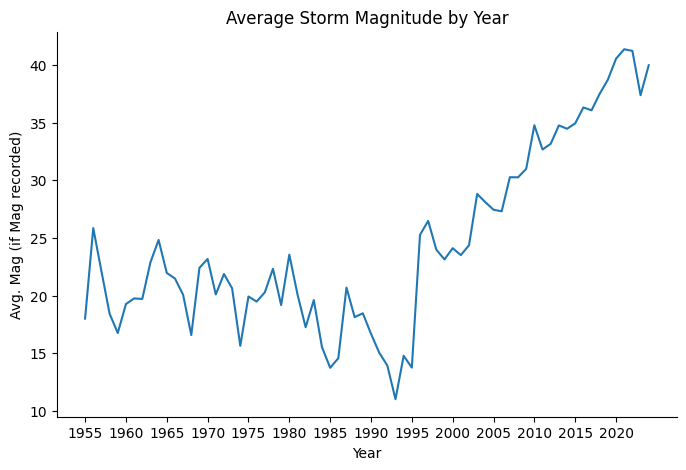

In [16]:
data = [d for d in Mag_avg if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values)
plt.title("Average Storm Magnitude by Year")
plt.xlabel("Year")
plt.xticks(years[::5])
plt.ylabel("Avg. Mag (if Mag recorded)")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


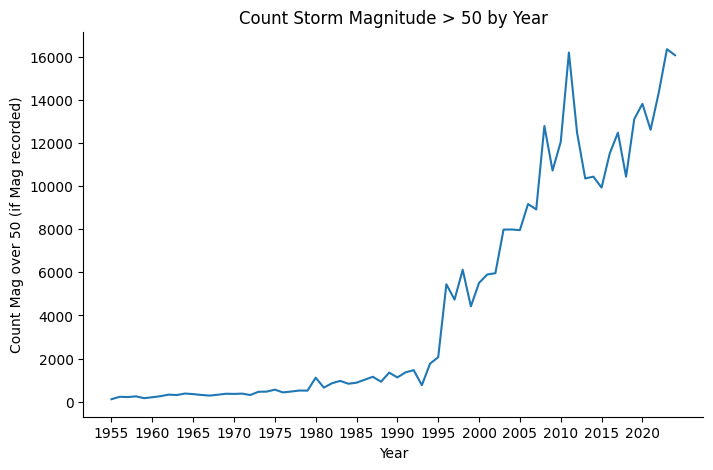

In [18]:
data = [d for d in Mag_over50 if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values)
plt.title("Count Storm Magnitude > 50 by Year")
plt.xlabel("Year")
plt.xticks(years[::5])
plt.ylabel("Count Mag over 50 (if Mag recorded)")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


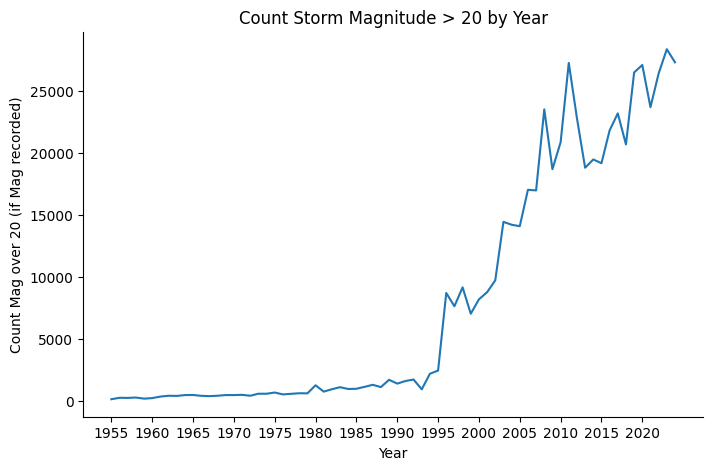

In [19]:
data = [d for d in Mag_over20 if d[0]!= 2025]

# Sort data by year
data_sorted = sorted(data)

years = [x[0] for x in data_sorted]
values = [x[1] for x in data_sorted]

plt.figure(figsize=(8, 5))
plt.plot(years, values)
plt.title("Count Storm Magnitude > 20 by Year")
plt.xlabel("Year")
plt.xticks(years[::5])
plt.ylabel("Count Mag over 20 (if Mag recorded)")
plt.grid(False)

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

In [23]:
sc.stop()